In [50]:
import pandas as pd
import numpy as np

In [51]:
df = pd.read_csv("/content/cleaned (1).csv", encoding="latin-1")

In [52]:
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Convert 'Order_Date' and 'Ship_Date' to datetime objects first
for col in ['Order_Date', 'Ship_Date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Handle potential errors during conversion

# Now apply toordinal()
for col in ['Order_Date', 'Ship_Date']:
    df[col] = df[col].apply(lambda x: x.toordinal() if pd.notna(x) else x)
# Define features (X) and target variable (y)
X = df.drop(columns=["Sales"])
y = df["Sales"]

# Before splitting, convert categorical features to numerical using Label Encoding
categorical_features = X.select_dtypes(include=['object']).columns  # Select categorical columns

for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])


In [53]:
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Import StandardScaler along with LabelEncoder
from sklearn.decomposition import PCA
df_encoded = df.copy()
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in categorical_cols:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

# Convert 'Order_Date' and 'Ship_Date' to ordinal before scaling
# Assuming 'Order_Date' and 'Ship_Date' are in the DataFrame
for col in ['Order_Date', 'Ship_Date']:
    df_encoded[col] = pd.to_datetime(df_encoded[col]).apply(lambda x: x.toordinal())

# Define features (X) and target variable (y)
X = df_encoded.drop(columns=["Sales"])
y = df_encoded["Sales"]

# Standardize the data (PCA requires scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Now X contains only numerical data

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


In [54]:
# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance >= 0.95) + 1

# Apply PCA with optimal components
pca_optimal = PCA(n_components=optimal_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Output the optimal number of components
print(optimal_components)


11


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

# Assuming X_pca_optimal and y are already defined and loaded

# Step 1: Feature Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_pca_optimal)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # ✅ Fixed reshape issue

# Step 2: Define the Model Architecture
model = Sequential([
    Dense(256, input_dim=X_scaled.shape[1]),
    ReLU(),
    Dropout(0.3),
    Dense(128),
    ReLU(),
    Dropout(0.3),
    Dense(64),
    ReLU(),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Step 4: Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 5: Train the Model
history = model.fit(X_scaled, y_scaled, epochs=350, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Step 6: Evaluate the Model
loss, mae = model.evaluate(X_scaled, y_scaled)
print(f'Mean Absolute Error: {mae}')

# Step 7: Make Predictions
y_pred_scaled = model.predict(X_scaled)

# Step 8: Convert Predictions Back to Original Scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Step 9: Calculate R2 Score
r2 = r2_score(y, y_pred)
print(f'R2 Score: {r2}')

Epoch 1/350


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0287 - mae: 0.8312 - val_loss: 0.7814 - val_mae: 0.7090
Epoch 2/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8396 - mae: 0.7170 - val_loss: 0.7458 - val_mae: 0.6948
Epoch 3/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7711 - mae: 0.6847 - val_loss: 0.6764 - val_mae: 0.6496
Epoch 4/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7226 - mae: 0.6517 - val_loss: 0.6553 - val_mae: 0.6106
Epoch 5/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7029 - mae: 0.6383 - val_loss: 0.6351 - val_mae: 0.6199
Epoch 6/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7000 - mae: 0.6322 - val_loss: 0.6323 - val_mae: 0.5900
Epoch 7/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6810 - mae: 0.6166 - val_loss: 0.6326 - val_mae: 0.6007
Epoch 8/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6661 - mae: 0.6122 - val_loss: 0.6267 - val_mae: 0.5810
Epoch 9/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss:

In [57]:
import joblib
joblib.dump(encoder, "encoder.pkl")  # Change label_encoder to encoder
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [24]:
model.save_weights('trained_model.weights.h5')  # Saving model's weights

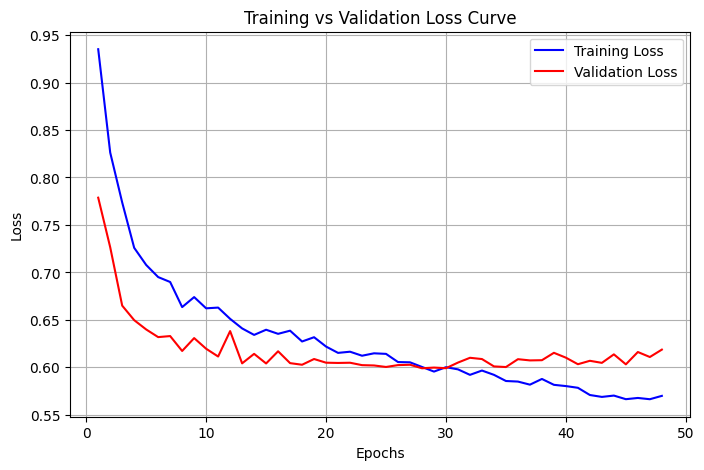

In [25]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
